## Введение в обработку естественного языка
### Урок 8. Рекуррентные нейронные сети RNN LSTM GRU

### Практическое задание  
На вебинаре мы говорили, что долгое время CNN и RNN архитектуры были конурируещими, необходимо выяснить какая архитектура больше подходит для задачи сантимент анализа на данных с вебинара.  
1. построить свёрточные архитектуры
2. построить различные архитектуры с RNN
3. попробовать использовать совместно CNN и RNN
4. сдлать выводы что получилось лучше

### Подключение библиотек и скриптов

In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:77% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# !pip install stop_words
# !pip install pymorphy2
# !pip install gensim

In [4]:
import time

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer

import nltk
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec, FastText

from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, linear_model
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

import tensorflow as tf
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D, Activation, MaxPooling2D, BatchNormalization, Concatenate
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import models
from tensorflow.keras import callbacks

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Busi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

In [7]:
def plot_model(history): 
    fig, axs = plt.subplots(1, 2, figsize=(16, 5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'], 'c') 
    axs[0].plot(history.history['val_accuracy'],'m') 
    axs[0].set_title('Accuracy of epochs')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epochs')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'], 'c') 
    axs[1].plot(history.history['val_loss'], 'm') 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epochs')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

### Tensorflow with GPU

In [8]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#     raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

### Загрузка данных

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

In [136]:
# df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/my_projects/data/train.csv')
# df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/my_projects/data/test.csv')
# df_val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/my_projects/data/val.csv')
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_val = pd.read_csv('./data/val.csv')

### Изучение датасета

In [137]:
df_train.head()

,id,text,class
0,0,"@alisachachka не уезжаааааааай. :(❤ я тоже не хочу, чтобы ты уезжала.",0
1,1,"RT @GalyginVadim: Ребята и девчата!\r\nВсе в кино!!! ""Вот Это Любовь!""\r\nСегодня! Завтра! И потом!)))))\r\n#вотэтолюбовь",1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретвит((((( RT,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Запретный плод. :),1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса не боится мороза и .......)),1


In [138]:
df_test.head()

,id,text
0,204150,Тектоника и рельеф-самое ужасное в мире мучение(
1,204151,"Ходили запускать шар желаний, но у нас не получилось(( ну и хрен с ним"
2,204152,"Хочу лето только ради того, что бы направить ногти ярким лаком :)"
3,204153,"RT @RonyLiss: @colf_ne блин((\r\nа я шипперила ФлораБлум\r\nИ МузаТекна\r\nА Стеллу.. не помню, ахах"
4,204154,"RT @anna_romt: @ZADROT_PO_IGRAM блин,каждое воскресенье утром выходит:( а сегодня ..какашка:(просто я иду человека фоткать и мне нужно солн…"


In [139]:
df_val.head()

,id,text,class
0,181467,RT @TukvaSociopat: Максимальный репост! ))) #євромайдан http://t.co/wxtQ0xGVtp,1
1,181468,"чтоб у меня з.п. ежегодно индексировали на индекс инфляции, как тарифы на автобусы! :(",0
2,181469,@chilyandlime нехуя мне не хорошо !!! :((((,0
3,181470,"@inafish нее , когда ногами ахахах когда?ахаха честн не помню , я тебе завтра в шк покажу как меня прикона пиздят ~((((",0
4,181471,"Хочу сделать как лучше, а получаю как всегда. :(",0


In [140]:
df_train.tail()

,id,text,class
181462,181462,Классным будет новый год..( http://t.co/LejaGuXNwu,0
181463,181463,Видишь человека хочешь сказать ему привет . А он тебя игнорит :(,0
181464,181464,@Julia6_9Styles там длинный диагноз. Вкратце: аллергический отёк горла с осложнением в виде фолликулярной ангины :(,0
181465,181465,"@technoslav ух ты, а кому тот серенький кнопочне телефон достанется ;)",1
181466,181466,"@Kris1D_07 я тоже так собираюсь сделать:D навешаю фоток вандюх:D \r\nобязательно выложи фотку, как нарядишь:3",1


In [141]:
df_test.tail()

,id,text
22679,226829,"RT @NickValuev: Небоскребы, небоскребы, а я маленький такой:) http://t.co/ZJ3H12KPPK"
22680,226830,"Первый день в школе в новом году;( 3 человека спросили: все ли у меня в порядке?.. Черный я любою, вот и все"
22681,226831,RT @Killgay_slut: @Your_Novocaine привеееет муда... какой к черту Сэмми? (
22682,226832,"Настроение вроде нормальное, но от чего плакать хочется("
22683,226833,"зашла перед сном к девчонкам)пока они мыли посуду,Настя фоткалась) http://t.co/kiNexuDTuh"


In [142]:
df_val.tail()

,id,text,class
22678,204145,А я знаю из-за кого такая паршивая погода была сегодня))),1
22679,204146,ааа.... что с Гмейлом. не ужто он умер сегодня :( именно в тот день когда мне надо сдавать журнал в печать,0
22680,204147,"в учебники химии написано ""Пруст Жозеф Луи""\r\nя явно подумала не о том Жозефе и не о том Луи:DD",1
22681,204148,"Вот все любят,а я не люблю..как дура..говорю,что люблю..а сама..(",0
22682,204149,"уххх спасибо дорогой Леле Евгеньевне и Штепуху за сегодняшний все было очень круто ,ну как обычно )))) нас даже научили как готовить бутеры",1


In [143]:
print(df_train.shape, df_test.shape, df_val.shape)

(181467, 3) (22684, 2) (22683, 3)


In [144]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181467 entries, 0 to 181466
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      181467 non-null  int64 
 1   text    181467 non-null  object
 2   class   181467 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.2+ MB


In [145]:
df_train.isnull().sum()

id       0
text     0
class    0
dtype: int64

In [146]:
df_test.isnull().sum()

id      0
text    0
dtype: int64

In [147]:
df_val.isnull().sum()

id       0
text     0
class    0
dtype: int64

### Предобработка

In [148]:
sw = set(get_stop_words('ru'))
exclude = set(punctuation)
morpher = MorphAnalyzer()

In [149]:
def preprocess_reviews(reviews):
    reviews = str(reviews)
    reviews = ''.join(c for c in reviews if c not in exclude)
    reviews = reviews.lower()
    reviews = re.sub("\sне", "не", reviews)
    reviews = [morpher.parse(word)[0].normal_form for word in reviews.split() if word not in sw]
    return " ".join(reviews)

In [150]:
df_train['text'] = df_train['text'].apply(preprocess_reviews)
df_test['text'] = df_test['text'].apply(preprocess_reviews)
df_val['text'] = df_val['text'].apply(preprocess_reviews)

In [151]:
df_train.head(3)

,id,text,class
0,0,alisachachkaич уезжаааааааать ❤ тожена хотеть уезжать,0
1,1,rt galyginvadim ребята девчата кино любовь завтра вотэтолюбовь,1
2,2,rt artemklyushin ктоненавидеть пробка ретвит rt,0


In [152]:
df_test.head(3)

,id,text
0,204150,тектоника рельефсамый ужасный мир мучение
1,204151,ходить запускать шар желание насна получиться хрен они
2,204152,хотеть лето ради направить ноготь яркий лак


In [153]:
df_val.head(3)

,id,text,class
0,181467,rt tukvasociopat максимальный репост євромайдан httptcowxtq0xgvtp,1
1,181468,зп ежегодно индексировать индекс инфляция тариф автобус,0
2,181469,chilyandlimeнеховать мнен,0


### 0. Baseline

In [154]:
X_train = df_train['text']
y_train = df_train['class']
X_test = df_val['text']
y_test = df_val['class']

In [155]:
# # labelEncode целевую переменную
# encoder = preprocessing.LabelEncoder()
# y_train = encoder.fit_transform(y_train)
# y_test = encoder.fit_transform(y_test)

In [156]:
models = []

models.append(('CountVectorizer_LR', CountVectorizer()))
models.append(('TfidfVectorizer_LR', TfidfVectorizer()))
models.append(('HashingVectorizer_LR', HashingVectorizer()))

In [157]:
# Logistic Regression
start_time = time.time()
classifier = linear_model.LogisticRegression()

results = []

for name, model in models:
    model.fit(X_train)
    X_train_count = model.transform(X_train)
    X_test_count = model.transform(X_test)
    
    classifier.fit(X_train_count, y_train)
    predictions_train = classifier.predict(X_train_count)
    predictions_test = classifier.predict(X_test_count)
    
    train_accuracy = accuracy_score(y_train, predictions_train)
    test_accuracy = accuracy_score(y_test, predictions_test)

    results.append((name, train_accuracy, test_accuracy))
    
lr_time = (time.time() - start_time)

In [158]:
lr_time

33.525192975997925

In [171]:
baseline_lr = pd.DataFrame((results))
baseline_lr.columns = ['model', 'train_accuracy', 'test_accuracy']
baseline_lr.sort_values('test_accuracy', ascending=False)

,model,train_accuracy,test_accuracy
0,CountVectorizer_LR,0.90322,0.74020
1,TfidfVectorizer_LR,0.84280,0.73698
2,HashingVectorizer_LR,0.80860,0.72654


In [172]:
models = []

models.append(('CountVectorizer_LSVC', CountVectorizer()))
models.append(('TfidfVectorizer_LSVC', TfidfVectorizer()))
models.append(('HashingVectorizer_LSVC', HashingVectorizer()))

In [173]:
# LinearSVC
start_time = time.time()
classifier = LinearSVC()

results = []

for name, model in models:
    model.fit(X_train)
    X_train_count = model.transform(X_train)
    X_test_count = model.transform(X_test)
    
    classifier.fit(X_train_count, y_train)
    predictions_train = classifier.predict(X_train_count)
    predictions_test = classifier.predict(X_test_count)
    
    train_accuracy = accuracy_score(y_train, predictions_train)
    test_accuracy = accuracy_score(y_test, predictions_test)

    results.append((name, train_accuracy, test_accuracy))

lsvc_time = (time.time() - start_time)    

In [174]:
lsvc_time

41.8368194103241

In [175]:
baseline_lsvc = pd.DataFrame(results)
baseline_lsvc.columns = ['model', 'train_accuracy', 'test_accuracy']
baseline_lsvc.sort_values('test_accuracy', ascending=False)

,model,train_accuracy,test_accuracy
1,TfidfVectorizer_LSVC,0.96287,0.73817
2,HashingVectorizer_LSVC,0.93225,0.73782
0,CountVectorizer_LSVC,0.97973,0.72777


### Word Embeddings

In [36]:
text_corpus_train = df_train['text'].values
text_corpus_valid = df_val['text'].values
text_corpus_test = df_test['text'].values

In [37]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [38]:
tokenizer = Tokenizer(num_words=None, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1 # Adding 1 because of reserved 0 index
training_length = max([len(i.split()) for i in text_corpus_train])

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)

In [39]:
y_train = df_train['class'].values
y_val = df_val['class'].values

### Simple model

In [40]:
# Training
epochs = 5
batch_size = 64

In [41]:
input_dim = X_train.shape[1]  # Number of features

In [42]:
model_1 = Sequential([
    layers.Dense(32, input_dim=input_dim, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [43]:
model_1.compile(optimizer='RMSprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [44]:
start_time = time.time()
history_1 = model_1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time1 = (time.time() - start_time)

Epoch 1/5
2836/2836 [==============================] - 2s 568us/step - loss: 527.3047 - accuracy: 0.5153 - val_loss: 115.1070 - val_accuracy: 0.5057
Epoch 2/5
2836/2836 [==============================] - 2s 530us/step - loss: 157.4928 - accuracy: 0.5196 - val_loss: 90.5847 - val_accuracy: 0.5110
Epoch 3/5
2836/2836 [==============================] - 2s 532us/step - loss: 110.3631 - accuracy: 0.5218 - val_loss: 56.1341 - val_accuracy: 0.5136
Epoch 4/5
2836/2836 [==============================] - 2s 539us/step - loss: 79.4936 - accuracy: 0.5231 - val_loss: 25.7455 - val_accuracy: 0.5183
Epoch 5/5
2836/2836 [==============================] - 2s 546us/step - loss: 66.3692 - accuracy: 0.5241 - val_loss: 9.7179 - val_accuracy: 0.5126


In [45]:
model_time1

8.107840061187744

In [46]:
score_train1 = model_1.evaluate(X_train, y_train, verbose=0)
score_test1 = model_1.evaluate(X_valid, y_val, verbose=0)

In [47]:
print('Train loss:', score_train1[0])
print('Train accuracy:', score_train1[1])
print('Test loss:', score_test1[0])
print('Test accuracy:', score_test1[1])

Train loss: 24.033992767333984
Train accuracy: 0.5359707474708557
Test loss: 9.717957496643066
Test accuracy: 0.5125865340232849


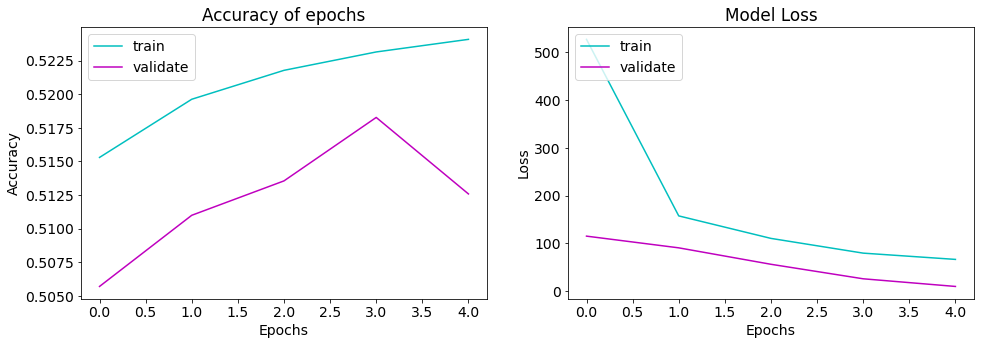

In [48]:
plot_model(history_1)

In [127]:
result_1 = pd.DataFrame((score_train1[1], score_test1[1], score_train1[0], score_test1[0], model_time1)).T
result_1.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss', 'time']
result_1['model'] = 'Simple model'

### Embedding Layer

In [50]:
embedding_dim = 100

In [51]:
model_2 = Sequential([
    layers.Embedding(input_dim=word_count, output_dim=embedding_dim, input_length=training_length),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [52]:
model_2.compile(optimizer='RMSprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [53]:
start_time = time.time()
history_2 = model_2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time2 = (time.time() - start_time)

Epoch 1/5
2836/2836 [==============================] - 291s 103ms/step - loss: 0.5373 - accuracy: 0.7185 - val_loss: 0.5357 - val_accuracy: 0.7222
Epoch 2/5
2836/2836 [==============================] - 342s 121ms/step - loss: 0.4387 - accuracy: 0.7976 - val_loss: 0.5433 - val_accuracy: 0.7309
Epoch 3/5
2836/2836 [==============================] - 294s 104ms/step - loss: 0.3372 - accuracy: 0.8576 - val_loss: 0.5867 - val_accuracy: 0.7268
Epoch 4/5
2836/2836 [==============================] - 292s 103ms/step - loss: 0.2510 - accuracy: 0.9010 - val_loss: 0.6594 - val_accuracy: 0.7105
Epoch 5/5
2836/2836 [==============================] - 342s 121ms/step - loss: 0.1891 - accuracy: 0.9286 - val_loss: 0.7182 - val_accuracy: 0.7084


In [54]:
model_time2

1561.7898819446564

In [55]:
score_train2 = model_2.evaluate(X_train, y_train, verbose=0)
score_test2 = model_2.evaluate(X_valid, y_val, verbose=0)

In [56]:
print('Train loss:', score_train2[0])
print('Train accuracy:', score_train2[1])
print('Test loss:', score_test2[0])
print('Test accuracy:', score_test2[1])

Train loss: 0.12443450093269348
Train accuracy: 0.9557660818099976
Test loss: 0.7182421684265137
Test accuracy: 0.7083719372749329


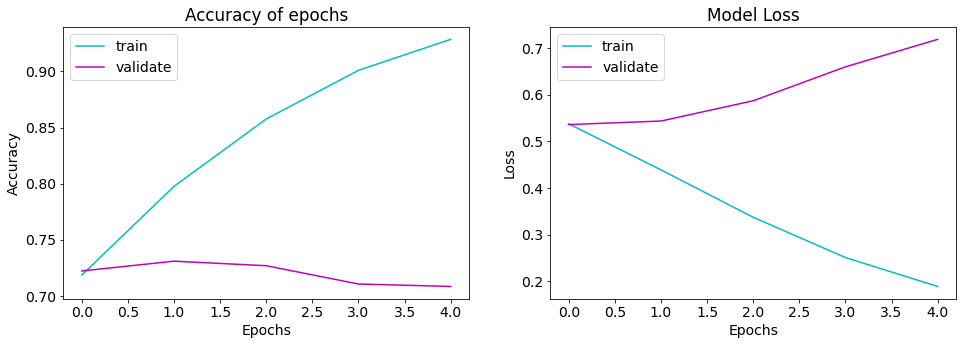

In [57]:
plot_model(history_2)

In [126]:
result_2 = pd.DataFrame((score_train2[1], score_test2[1], score_train2[0], score_test2[0], model_time2)).T
result_2.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss', 'time']
result_2['model'] = 'Embedding Layer'

### Add GlobalMaxPool1D

In [59]:
model_3 = Sequential([
    layers.Embedding(input_dim=word_count, output_dim=embedding_dim, input_length=training_length),
    layers.GlobalMaxPool1D(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [60]:
model_3.compile(optimizer='RMSprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [61]:
start_time = time.time()
history_3 = model_2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time3 = (time.time() - start_time)

Epoch 1/5
2836/2836 [==============================] - 341s 120ms/step - loss: 0.1453 - accuracy: 0.9465 - val_loss: 0.7685 - val_accuracy: 0.7111
Epoch 2/5
2836/2836 [==============================] - 319s 112ms/step - loss: 0.1137 - accuracy: 0.9584 - val_loss: 0.8755 - val_accuracy: 0.6906
Epoch 3/5
2836/2836 [==============================] - 279s 98ms/step - loss: 0.0899 - accuracy: 0.9677 - val_loss: 0.9475 - val_accuracy: 0.6816
Epoch 4/5
2836/2836 [==============================] - 280s 99ms/step - loss: 0.0725 - accuracy: 0.9743 - val_loss: 1.0052 - val_accuracy: 0.6988
Epoch 5/5
2836/2836 [==============================] - 289s 102ms/step - loss: 0.0592 - accuracy: 0.9793 - val_loss: 1.0313 - val_accuracy: 0.6913


In [62]:
model_time3

1508.0989789962769

In [63]:
score_train3 = model_3.evaluate(X_train, y_train, verbose=0)
score_test3 = model_3.evaluate(X_valid, y_val, verbose=0)

In [64]:
print('Train loss:', score_train3[0])
print('Train accuracy:', score_train3[1])
print('Test loss:', score_test3[0])
print('Test accuracy:', score_test3[1])

Train loss: 0.6921553015708923
Train accuracy: 0.5156529545783997
Test loss: 0.6925776600837708
Test accuracy: 0.5127187967300415


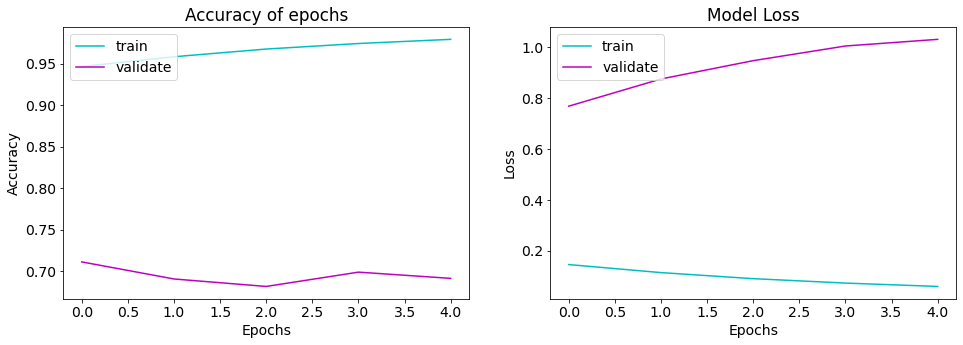

In [65]:
plot_model(history_3)

In [125]:
result_3 = pd.DataFrame((score_train3[1], score_test3[1], score_train3[0], score_test3[0], model_time3)).T
result_3.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss', 'time']
result_3['model'] = 'Add GlobalMaxPool1D'

### Convolutional Neural Networks (CNN)

In [67]:
model_4 = Sequential([
    layers.Embedding(input_dim=word_count, output_dim=embedding_dim, input_length=training_length),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPool1D(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [68]:
model_4.compile(optimizer='RMSprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [69]:
start_time = time.time()
history_4 = model_4.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time4 = (time.time() - start_time)

Epoch 1/5
2836/2836 [==============================] - 294s 104ms/step - loss: 0.5298 - accuracy: 0.7253 - val_loss: 0.5419 - val_accuracy: 0.7210
Epoch 2/5
2836/2836 [==============================] - 305s 107ms/step - loss: 0.3941 - accuracy: 0.8247 - val_loss: 0.5432 - val_accuracy: 0.7381
Epoch 3/5
2836/2836 [==============================] - 347s 122ms/step - loss: 0.2385 - accuracy: 0.9056 - val_loss: 0.6369 - val_accuracy: 0.7447
Epoch 4/5
2836/2836 [==============================] - 291s 103ms/step - loss: 0.1404 - accuracy: 0.9493 - val_loss: 0.7045 - val_accuracy: 0.7306
Epoch 5/5
2836/2836 [==============================] - 294s 104ms/step - loss: 0.0872 - accuracy: 0.9695 - val_loss: 0.7986 - val_accuracy: 0.7182


In [70]:
model_time4

1530.8783793449402

In [71]:
score_train4 = model_4.evaluate(X_train, y_train, verbose=0)
score_test4 = model_4.evaluate(X_valid, y_val, verbose=0)

In [72]:
print('Train loss:', score_train3[0])
print('Train accuracy:', score_train3[1])
print('Test loss:', score_test3[0])
print('Test accuracy:', score_test3[1])

Train loss: 0.6921553015708923
Train accuracy: 0.5156529545783997
Test loss: 0.6925776600837708
Test accuracy: 0.5127187967300415


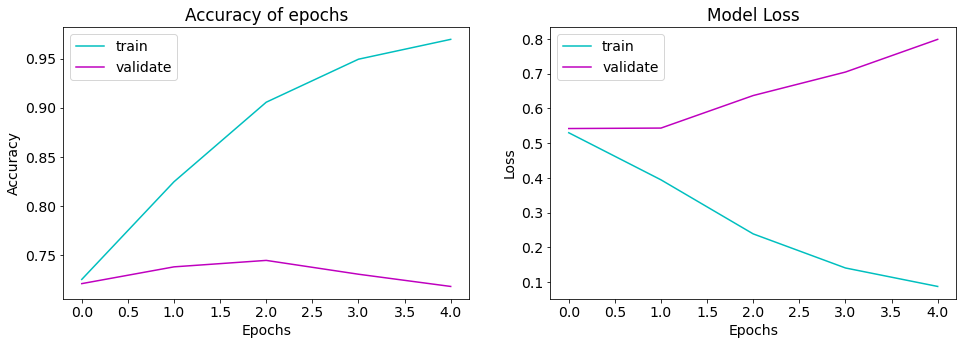

In [73]:
plot_model(history_4)

In [124]:
result_4 = pd.DataFrame((score_train4[1], score_test4[1], score_train4[0], score_test4[0], model_time4)).T
result_4.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss', 'time']
result_4['model'] = 'CNN'

### Add Dropout

In [75]:
model_5 = Sequential([
    layers.Embedding(input_dim=word_count, output_dim=embedding_dim, input_length=training_length),
    layers.Dropout(0.2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPool1D(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [76]:
model_5.compile(optimizer='RMSprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [77]:
start_time = time.time()
history_5 = model_5.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time5 = (time.time() - start_time)

Epoch 1/5
2836/2836 [==============================] - 292s 103ms/step - loss: 0.5389 - accuracy: 0.7191 - val_loss: 0.5314 - val_accuracy: 0.7265
Epoch 2/5
2836/2836 [==============================] - 289s 102ms/step - loss: 0.4332 - accuracy: 0.7994 - val_loss: 0.5382 - val_accuracy: 0.7461
Epoch 3/5
2836/2836 [==============================] - 302s 106ms/step - loss: 0.3155 - accuracy: 0.8692 - val_loss: 0.5815 - val_accuracy: 0.7504
Epoch 4/5
2836/2836 [==============================] - 302s 107ms/step - loss: 0.2255 - accuracy: 0.9126 - val_loss: 0.6397 - val_accuracy: 0.7356
Epoch 5/5
2836/2836 [==============================] - 414s 146ms/step - loss: 0.1700 - accuracy: 0.9374 - val_loss: 0.6410 - val_accuracy: 0.7353


In [78]:
model_time5

1600.0076489448547

In [79]:
score_train5 = model_5.evaluate(X_train, y_train, verbose=0)
score_test5 = model_5.evaluate(X_valid, y_val, verbose=0)

In [80]:
print('Train loss:', score_train3[0])
print('Train accuracy:', score_train3[1])
print('Test loss:', score_test3[0])
print('Test accuracy:', score_test3[1])

Train loss: 0.6921553015708923
Train accuracy: 0.5156529545783997
Test loss: 0.6925776600837708
Test accuracy: 0.5127187967300415


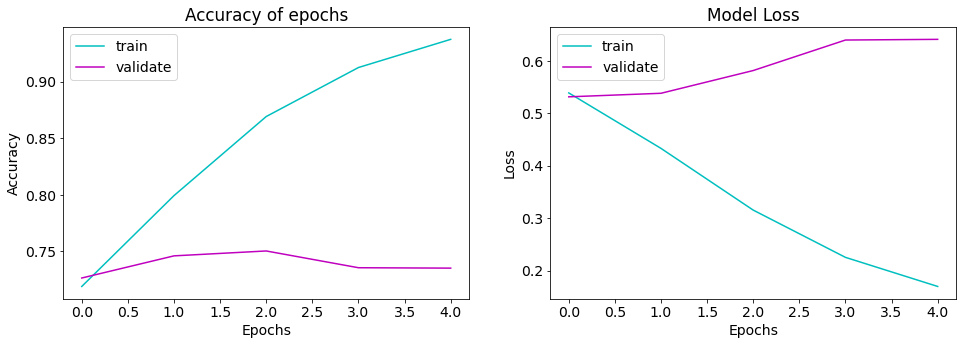

In [81]:
plot_model(history_5)

In [123]:
result_5 = pd.DataFrame((score_train5[1], score_test5[1], score_train5[0], score_test5[0], model_time5)).T
result_5.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss', 'time']
result_5['model'] = 'Add Dropout'

### CNN + LSTM

In [83]:
model_6 = Sequential([
    layers.Embedding(input_dim=word_count, output_dim=embedding_dim, input_length=training_length),
    layers.Dropout(0.2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [84]:
model_6.compile(optimizer='RMSprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [85]:
start_time = time.time()
history_6 = model_6.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time6 = (time.time() - start_time)

Epoch 1/5
2836/2836 [==============================] - 350s 124ms/step - loss: 0.5351 - accuracy: 0.7234 - val_loss: 0.5446 - val_accuracy: 0.7215
Epoch 2/5
2836/2836 [==============================] - 341s 120ms/step - loss: 0.3843 - accuracy: 0.8297 - val_loss: 0.5402 - val_accuracy: 0.7425
Epoch 3/5
2836/2836 [==============================] - 373s 131ms/step - loss: 0.2495 - accuracy: 0.8989 - val_loss: 0.5659 - val_accuracy: 0.7380
Epoch 4/5
2836/2836 [==============================] - 392s 138ms/step - loss: 0.1921 - accuracy: 0.9258 - val_loss: 0.6175 - val_accuracy: 0.7384
Epoch 5/5
2836/2836 [==============================] - 363s 128ms/step - loss: 0.1617 - accuracy: 0.9384 - val_loss: 0.6872 - val_accuracy: 0.7384


In [86]:
model_time6

1821.295545578003

In [87]:
score_train6 = model_6.evaluate(X_train, y_train, verbose=0)
score_test6 = model_6.evaluate(X_valid, y_val, verbose=0)

In [88]:
print('Train loss:', score_train6[0])
print('Train accuracy:', score_train6[1])
print('Test loss:', score_test6[0])
print('Test accuracy:', score_test6[1])

Train loss: 0.10517910867929459
Train accuracy: 0.9609846472740173
Test loss: 0.6872151494026184
Test accuracy: 0.7383503317832947


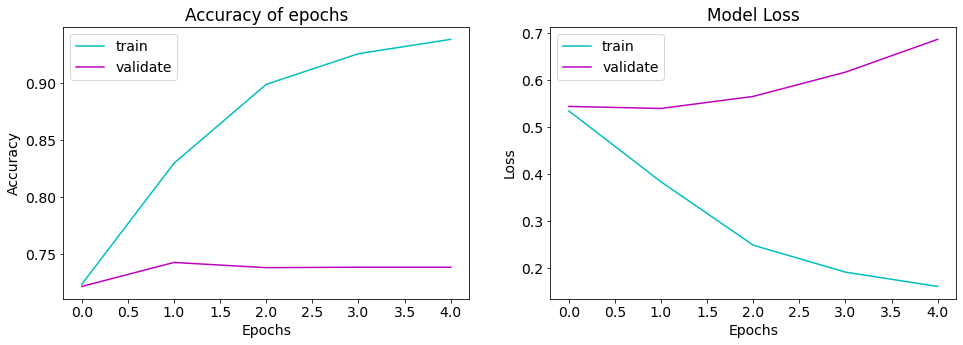

In [89]:
plot_model(history_6)

In [122]:
result_6 = pd.DataFrame((score_train6[1], score_test6[1], score_train6[0], score_test6[0], model_time6)).T
result_6.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss', 'time']
result_6['model'] = 'CNN + LSTM'

### GRU + CNN

In [91]:
model_7 = Sequential([
    layers.Embedding(input_dim=word_count, output_dim=embedding_dim, input_length=training_length),
    layers.Dropout(0.2),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(5, 10)),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPool1D(),
    layers.Dense(10, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [92]:
model_7.compile(optimizer='RMSprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [93]:
start_time = time.time()
history_7 = model_7.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time7 = (time.time() - start_time)

Epoch 1/5
2836/2836 [==============================] - 382s 135ms/step - loss: 0.5442 - accuracy: 0.7196 - val_loss: 0.5371 - val_accuracy: 0.7246
Epoch 2/5
2836/2836 [==============================] - 371s 131ms/step - loss: 0.4418 - accuracy: 0.7983 - val_loss: 0.5350 - val_accuracy: 0.7438
Epoch 3/5
2836/2836 [==============================] - 411s 145ms/step - loss: 0.3188 - accuracy: 0.8695 - val_loss: 0.5483 - val_accuracy: 0.7417
Epoch 4/5
2836/2836 [==============================] - 382s 135ms/step - loss: 0.2455 - accuracy: 0.9044 - val_loss: 0.6469 - val_accuracy: 0.7422
Epoch 5/5
2836/2836 [==============================] - 412s 145ms/step - loss: 0.2092 - accuracy: 0.9211 - val_loss: 0.6136 - val_accuracy: 0.7425


In [94]:
model_time7

1960.2335464954376

In [95]:
score_train7 = model_7.evaluate(X_train, y_train, verbose=0)
score_test7 = model_7.evaluate(X_valid, y_val, verbose=0)

In [96]:
print('Train loss:', score_train7[0])
print('Train accuracy:', score_train7[1])
print('Test loss:', score_test7[0])
print('Test accuracy:', score_test7[1])

Train loss: 0.1538601517677307
Train accuracy: 0.9410967230796814
Test loss: 0.6136409640312195
Test accuracy: 0.7424502968788147


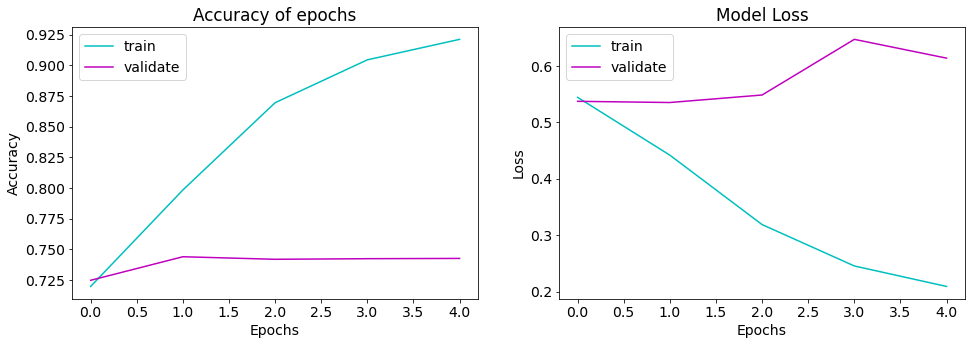

In [97]:
plot_model(history_7)

In [119]:
result_7 = pd.DataFrame((score_train7[1], score_test7[1], score_train7[0], score_test7[0], model_time7)).T
result_7.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss', 'time']
result_7['model'] = 'GRU + CNN'

### Results

In [176]:
final_results = pd.concat([baseline_lr, baseline_lsvc, result_1, result_2, result_3, result_4, result_5, result_6, result_7], axis=0)

In [177]:
final_results.sort_values('test_accuracy', ascending=False)

,model,train_accuracy,test_accuracy,train_loss,test_loss,time
0,GRU + CNN,0.94110,0.74245,0.15386,0.61364,1960.23355
0,CountVectorizer_LR,0.90322,0.74020,NaN,NaN,NaN
0,CNN + LSTM,0.96098,0.73835,0.10518,0.68722,1821.29555
1,TfidfVectorizer_LSVC,0.96287,0.73817,NaN,NaN,NaN
2,HashingVectorizer_LSVC,0.93225,0.73782,NaN,NaN,NaN
1,TfidfVectorizer_LR,0.84280,0.73698,NaN,NaN,NaN
0,Add Dropout,0.96749,0.73526,0.10050,0.64095,1600.00765
0,CountVectorizer_LSVC,0.97973,0.72777,NaN,NaN,NaN
2,HashingVectorizer_LR,0.80860,0.72654,NaN,NaN,NaN
0,CNN,0.98663,0.71816,0.04160,0.79861,1530.87838


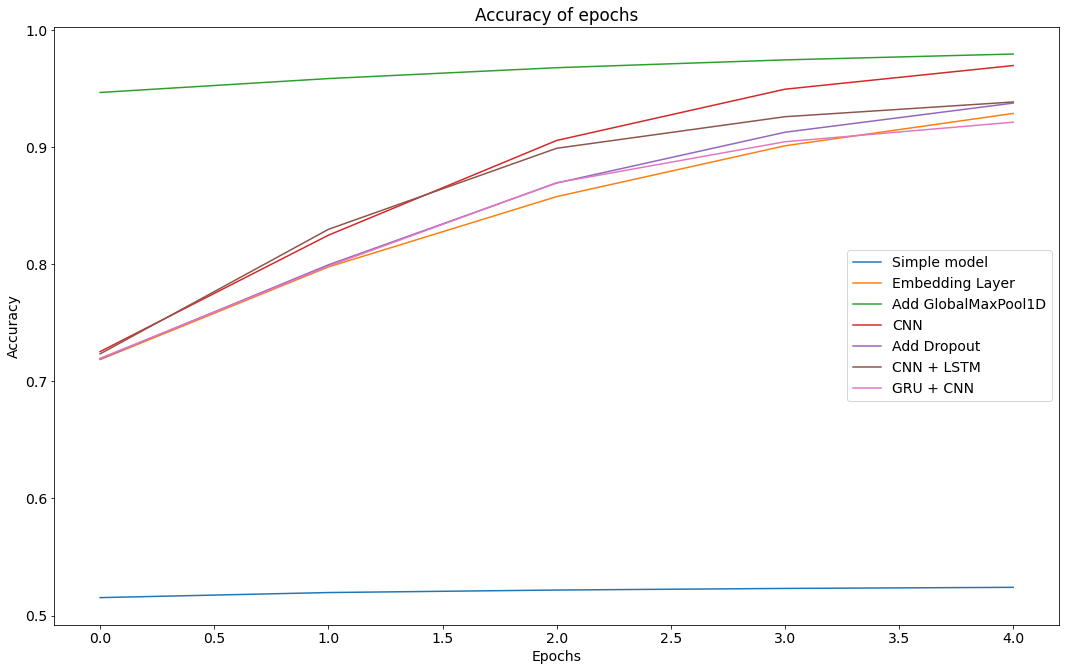

In [105]:
plt.figure(figsize=(18, 11))
plt.plot(history_1.history['accuracy'], label='Simple model')
plt.plot(history_2.history['accuracy'], label='Embedding Layer')
plt.plot(history_3.history['accuracy'], label='Add GlobalMaxPool1D')
plt.plot(history_4.history['accuracy'], label='CNN')
plt.plot(history_5.history['accuracy'], label='Add Dropout')
plt.plot(history_6.history['accuracy'], label='CNN + LSTM')
plt.plot(history_7.history['accuracy'], label='GRU + CNN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy of epochs')
plt.show()

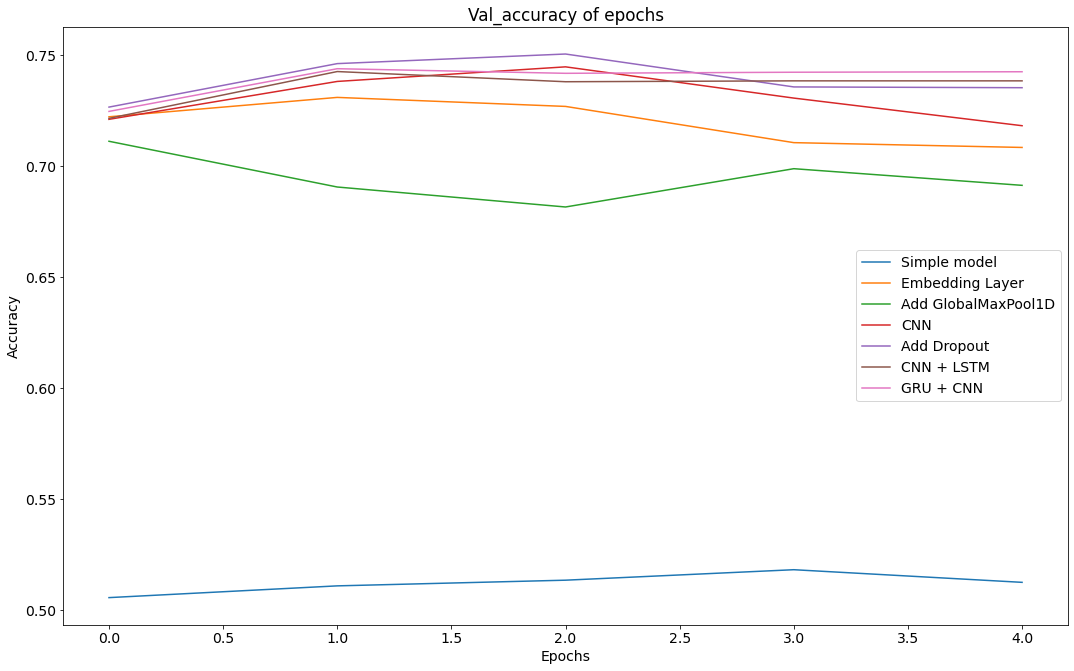

In [106]:
plt.figure(figsize=(18, 11))
plt.plot(history_1.history['val_accuracy'], label='Simple model')
plt.plot(history_2.history['val_accuracy'], label='Embedding Layer')
plt.plot(history_3.history['val_accuracy'], label='Add GlobalMaxPool1D')
plt.plot(history_4.history['val_accuracy'], label='CNN')
plt.plot(history_5.history['val_accuracy'], label='Add Dropout')
plt.plot(history_6.history['val_accuracy'], label='CNN + LSTM')
plt.plot(history_7.history['val_accuracy'], label='GRU + CNN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Val_accuracy of epochs')
plt.show()